# Homework - Alessandro Delmonte

## Config

The following line will install dependecies. I leave it as a comment to not mess up with your environment. I usually build a docker image when working with tensorflow, let me know if you need the dockerfile. I  trained the algorithms on a GPU (there are quite a few training loops) but the notebook should run without problems on CPU.

In [1]:
# !pip install tensorflow scikit-learn numpy pywavelets biosppy

In [2]:
# Just defining some standard imports and configs I like to use when working with notebooks

from __future__ import absolute_import, division, print_function, unicode_literals

%load_ext autoreload
%autoreload 2

import sys
assert sys.version_info.major == 3, 'Not running on Python 3'

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import logging
logging.basicConfig(level=logging.INFO, stream=sys.stdout)

# For plotting
import seaborn as sns
sns.set_context('notebook')
sns.set(style="whitegrid", font_scale=1.5)
sns.despine()

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [10, 5]

INFO:matplotlib.font_manager:generated new fontManager


## Problem statement

The ECG is a time series that measures the electrical activity of the heart. This is the main tool to diagnose heart diseases. Recording an ECG is simple: 3 electrodes are placed at the ends of limbs, and 6 on the anterior chest.This generates 12 time series, called leads, each corresponding to a difference in potential between a pair of electrodes.
The electrodes’ position is very important to correctly interpret the ECG. Making the mistake of inverting electrodes compromises interpretation, either because the leads do not explore the expected area (errors in the measures of hypertrophia indices, in the analysis of the ST segment), or because they generate false abnormalities (fake Q waves, error in the heart’s axis…).
Inversion errors are frequent (5% of ECGs), and only experts (cardiologists) manage to detect them. But most ECGs are not interpreted by experts: only 30% are, the rest being interpreted by nurses or general practitioners. An algorithm for automatic detection of electrode inversion is therefore paramount to the correct interpretation of ECGs and would improve the quality of diagnosis.
This project is intended to make you detect electrode inversion in an ECG. The dataset at your disposal contains ECGs from a cardiology center. An ECG will be labeled as correctly realised (0) or as inverted (1). The goal is to perform binary classification on these ECGs.

The key objective of this homework is to propose a model relevant to the task that shows good accuracy in detection of lead inversion.

## Data Analysis

Data:
- The training data contains 1400 ECGs and their labels. For each ECG, the data consists of 10 seconds of recording for 12 leads, each sampled at 250Hz.
- The testing data contains 2630 ECGs.
Each input file therefore contains the ECG signal in the form (n_ecgs, n_samples=2500, n_leads=12).

We got for the training set 1400 examples of a 10 seconds ECG (2500 steps sampled at 250Hz) for the 12 leads. This 3-dimensional formulation should be quite conventient to use with ML and DL algorithms. I will load the data and check some of them.

I assume the data are in the same folder of the notebook

In [3]:
import numpy as np

in_training_path = 'input_training.npy'
out_training_path = 'output_training.npy'
in_test_path = 'input_test_set.npy'

x_train_raw = np.load(in_training_path).swapaxes(1,2)
y_train_raw = np.load(out_training_path)
x_test_raw = np.load(in_test_path).swapaxes(1,2)

sampling_rate = 250

print('Training dataset shape: {} - Training labels shape: {} - Testing dataset shape: {}'.format(
    x_train_raw.shape, y_train_raw.shape, x_test_raw.shape))

Training dataset shape: (1400, 2500, 12) - Training labels shape: (1400,) - Testing dataset shape: (2630, 2500, 12)


The leads are on the second axis and the timesteps on the third axis. I will just transpose them to have data in the channel_last format

Visualizing a couple of ECG in order to better understand data. As stated in the problem formulation, inversion can impact any of the leads. I do not think I should simplify the problem removing some leads (I think the simplification of the problem via reduction of dimensionality would only cause loss of information)

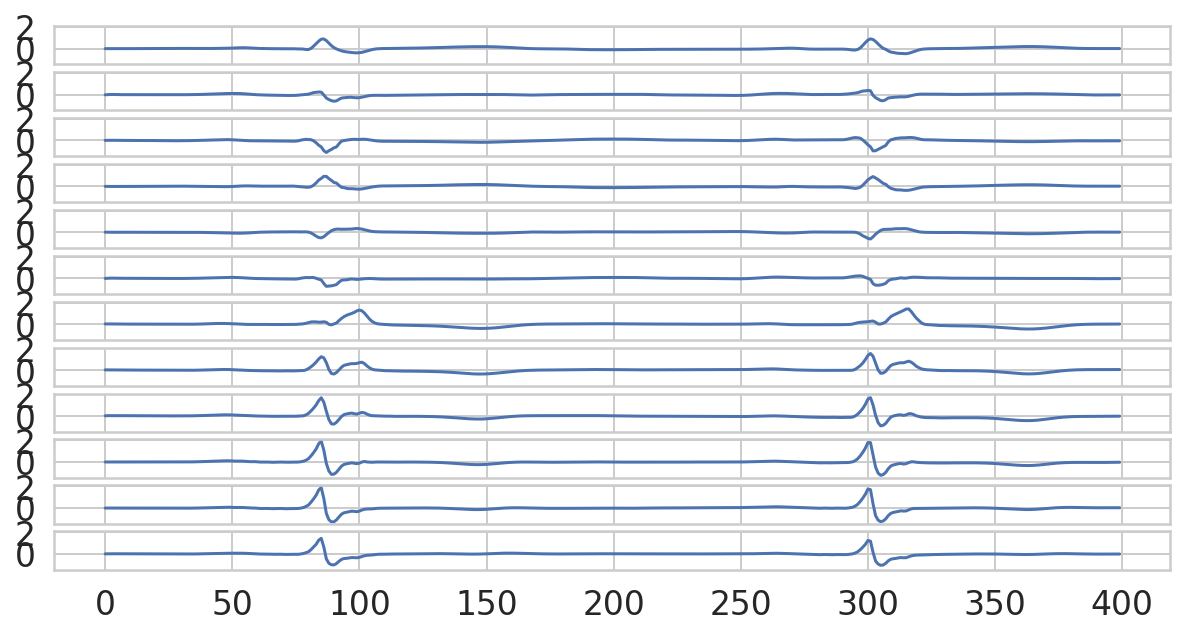

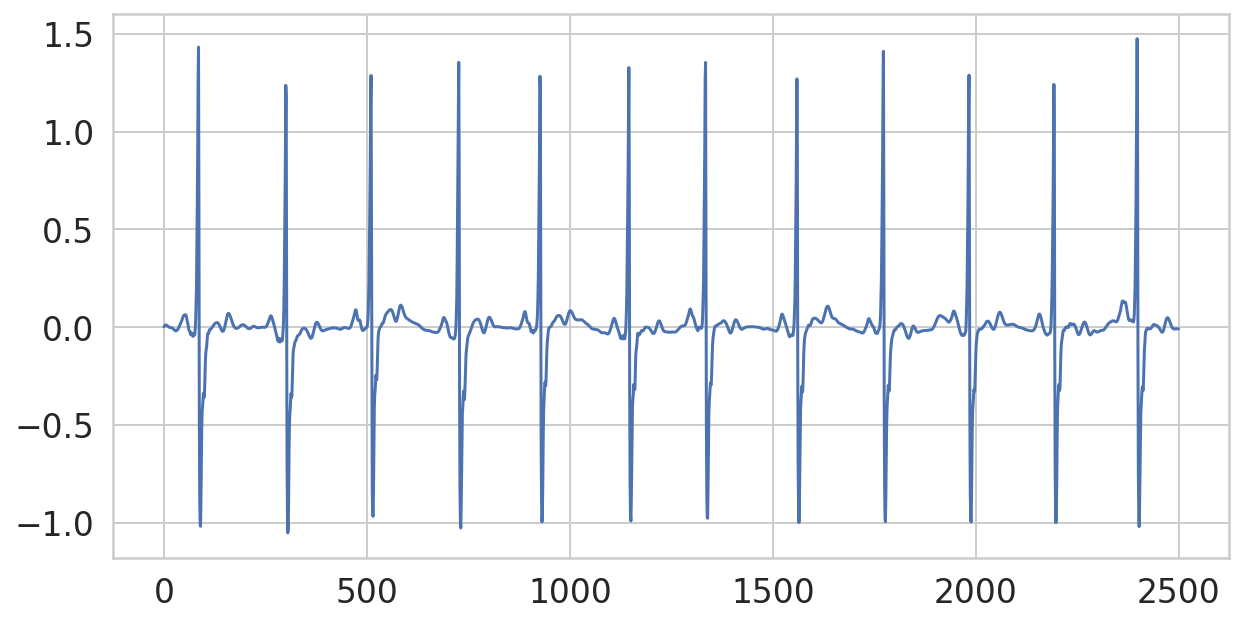

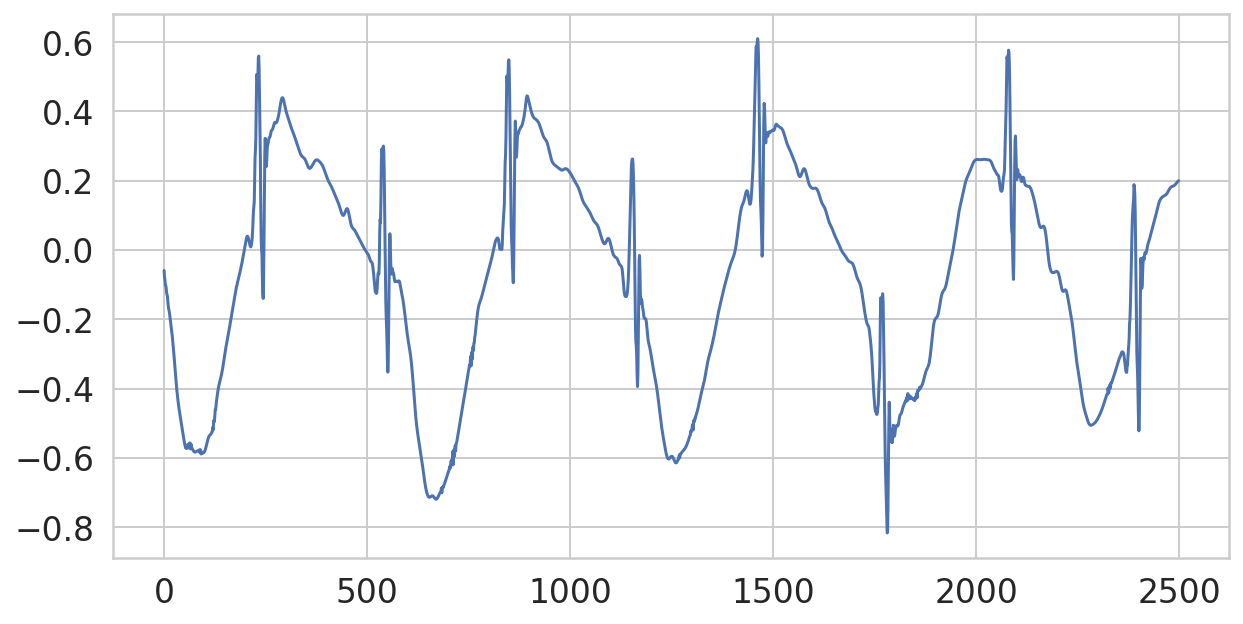

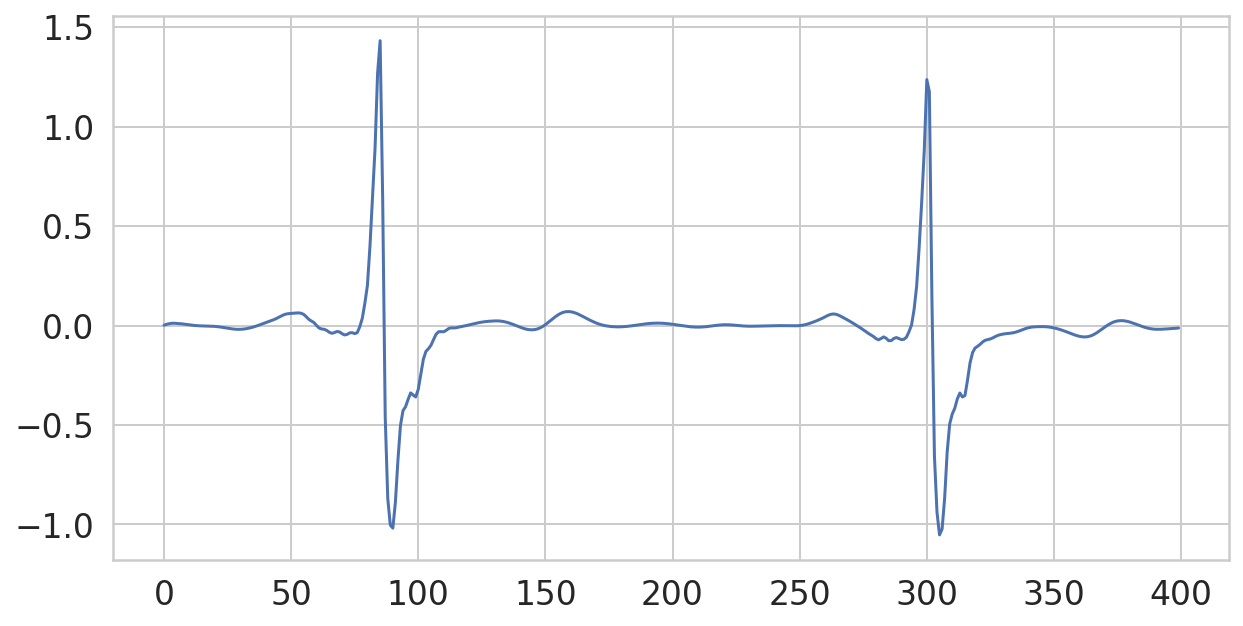

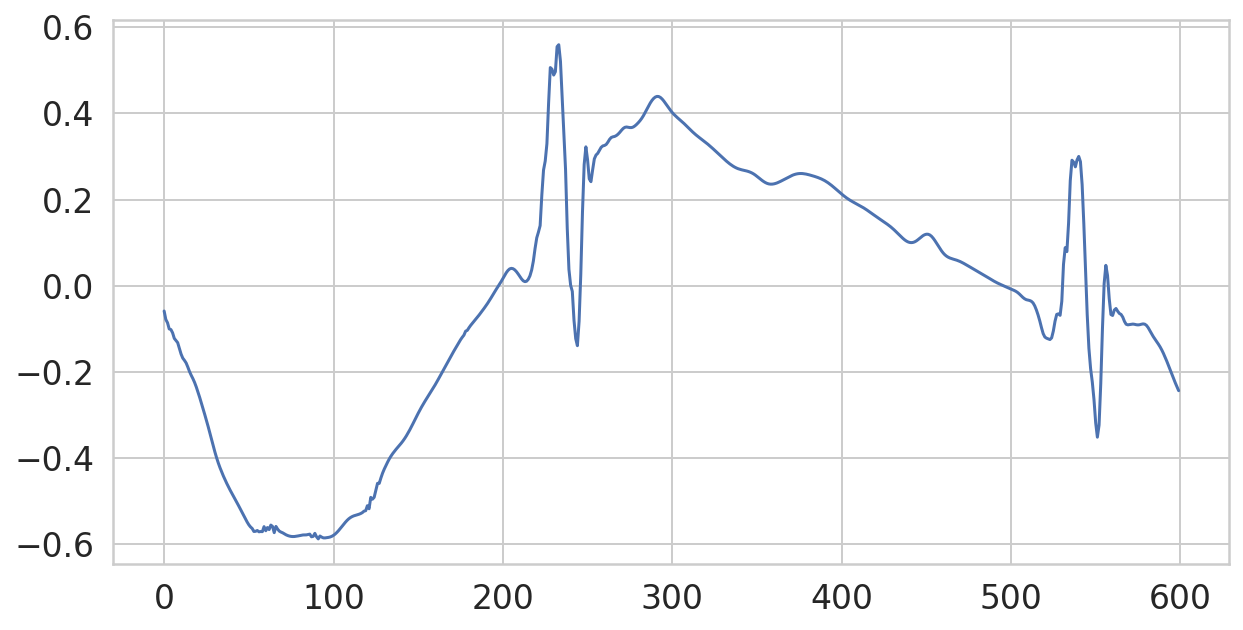

In [4]:
# All leads
fig, ax = plt.subplots(x_train_raw.shape[-1], 1, sharex=True, sharey=True)
for i in range(x_train_raw.shape[-1]):
    sns.lineplot(data=x_train_raw[0, :400, i], ax=ax[i])
plt.show();
# One lead
sns.lineplot(data=x_train_raw[0, :, 11])
plt.show();
# One lead
sns.lineplot(data=x_test_raw[2, :, 11])
plt.show();
# One lead - some cycles
sns.lineplot(data=x_train_raw[0, :400, 11])
plt.show();
sns.lineplot(data=x_test_raw[2, :600, 11])
plt.show();

All the leads are correctly loaded. I am not a trained cardiologist (maybe a cardiologs soon ;) ) but the signal looks clean overall. A small drift is visible when looking at the 10s interval (but it seems that it has already been corrected) and some high frequency artifacts can be seen when zooming in on the test dataset. As confirmed by mail, the test set share the same statistics of the training set so I can use the same preprocessing pipeline for the two.

The training set size is relatively small, especially if compared to the test set. I might consider some data augmentation but I should be careful not to insert samples without physiological meaning.

It is interesting to check the label distribution in order to see if there is a significant imbalance in the training set. If the dataset is unbalanced I might think about oversampling the minority class (with caution to avoid overfitting on the minority data, especially when using such a small dataset). I might also undersample the majority class or just assign weights in the loss function.

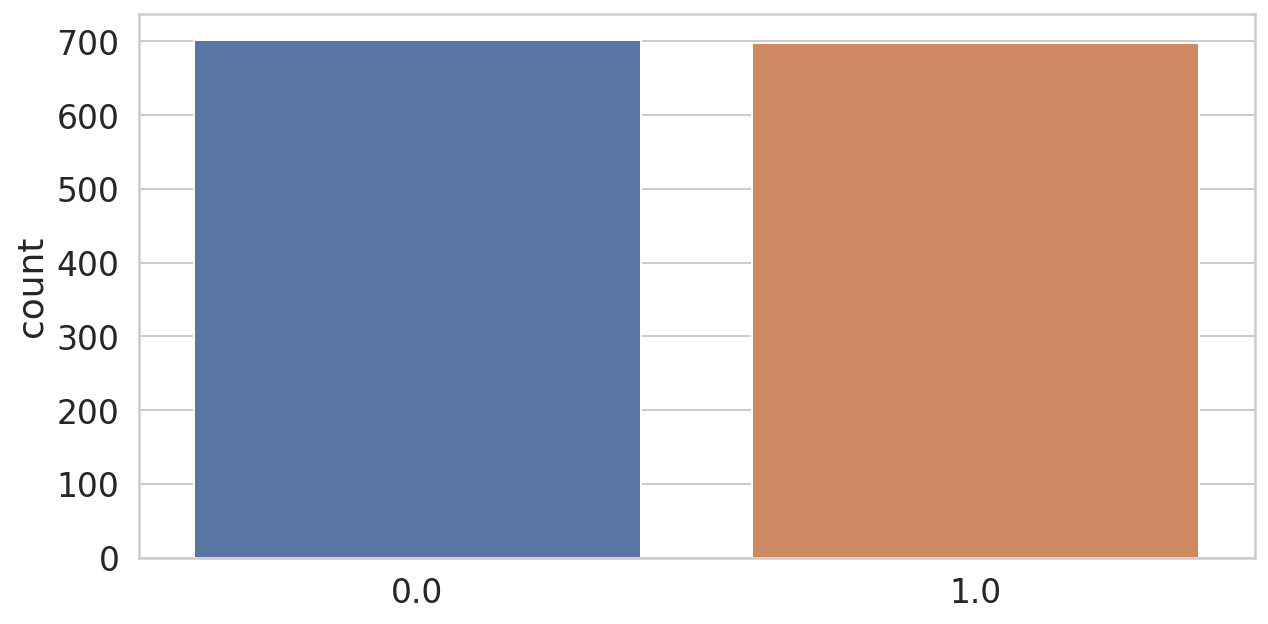

In [5]:
sns.countplot(x=y_train_raw)
plt.show();

The dataset is perfectly balanced. For the moment I won't do more but I will come back to data augmentation if the final scores are not satisfying. Precision and recall should be good performance metrics as well as accuracy. I would try to maximise recall over precision since for medical application I prefer an algorithm that do not miss any true positive, even if it creates false alerts sometimes.

## Outline of solution

Supervised learning seems the way to go. I will use the training set and the given labels to train a ML/DL algorithm to predict the class of the test set. My strategy will be: clean the data, define a first the model, define the training strategy, tune the hyperparameters, explore more sophisticated options to generalise predictions.

## Data Pre-Processing

I will start with preprocessing since in any case I need to prepare the data. Looking at the data I may use several pre-processing steps in order to denoise high frequencies artifcats, removal low frequency drift and normalize the scale.
For denoising and drift removal I might use a wavelet based analysis which could be enough to remove both. Even if the number of decomposition levels and the thresholding value might be hard to optimize. A FIR filter should also be OK. 
I might opt to downsample the signal to remove noise but it is not a mandatory step since every sample has the same sampling rate (might obtain improvements with a lower sampling rate? it might reduce noise but lose some information, to be eventually explored). 
For normalization I could just min-max scale the values in the range [0,1] (or [-1, 1] since negative values have a physiological meaning). I could also just do a z-score standardization. I think it might be better to have the baseline at 0. For the mean and the std I can just use the global statistics of the training dataset ( I dont want to touch the test dataset to avoid influencing the results).

From a quick research of the state-of-the-art it seems that a wavelet approach might be enough for denoising. Wavelets decompose the signal in approximate and detailed coefficients. Appoximate coefficients represents low frequency components and detailed coeff represent high frequency components. db4 or db5 should be the wavelets better suited to ecg analysis. pywavelets does suport a lot of them so it is not productive to spend time on the choice. start with db4 and I might chek db5 if i got some time remaining. I may compute the order based on the length of the samples and the threshold based on what I found in the SOTA. I should be able to filter the signal by thresholding both types of coefficients.

/usr/local/lib/python3.8/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 11 is too high: all coefficients will experience boundary effects.
  warnings.warn(


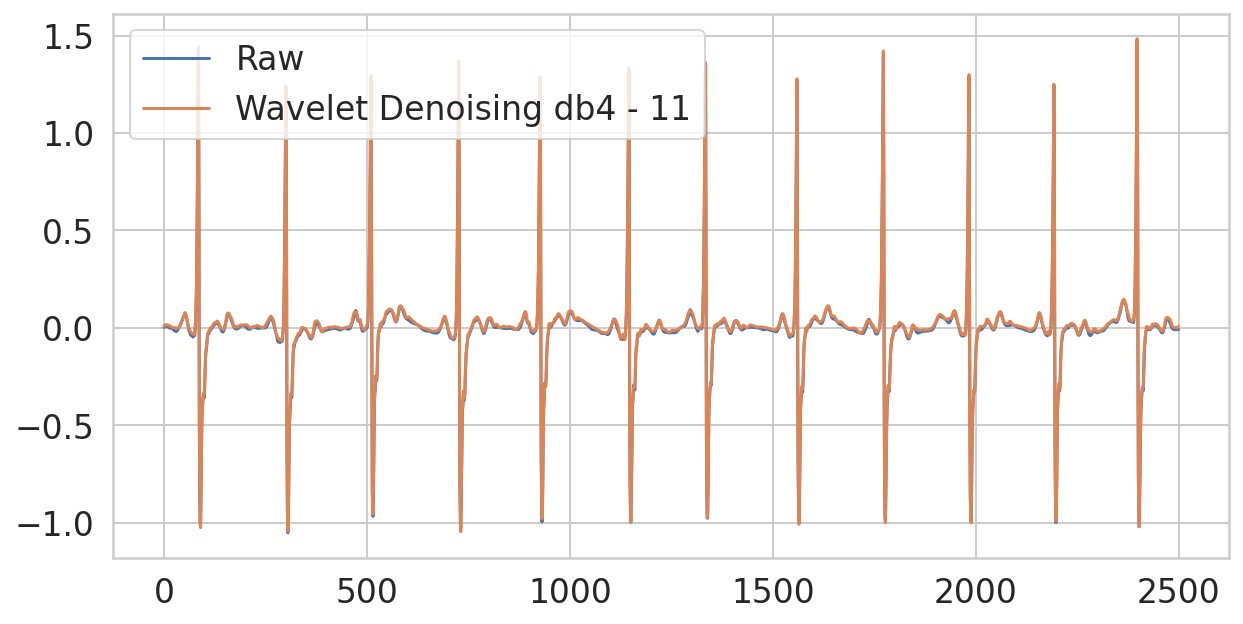

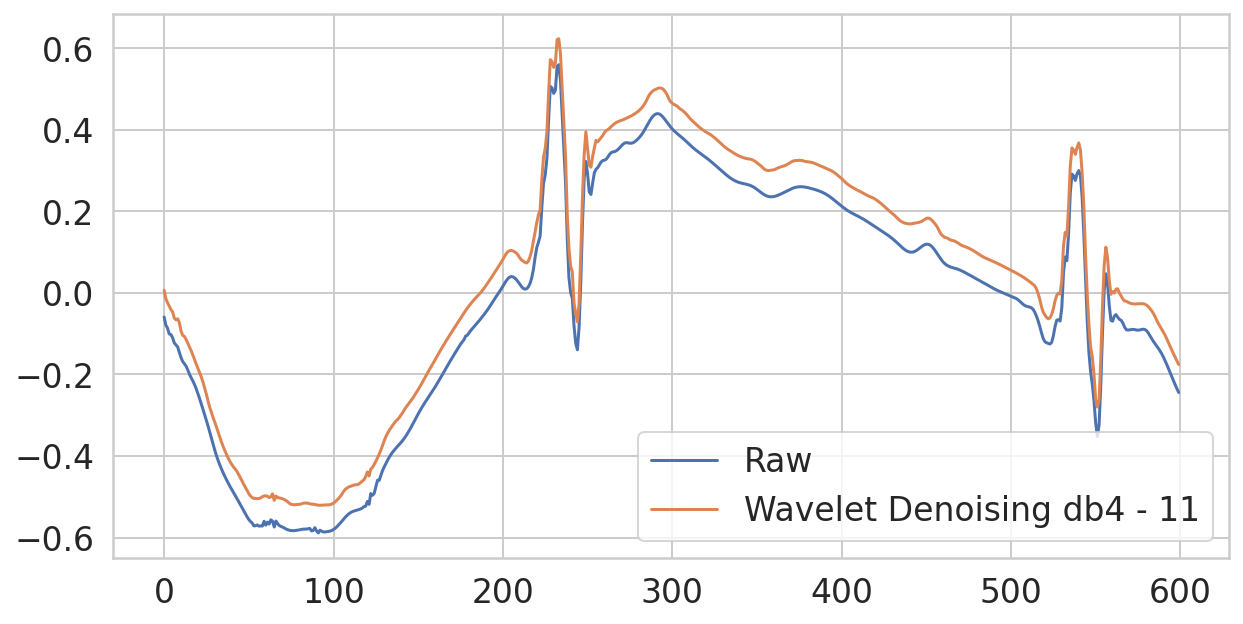

In [6]:
import pywt

def wtd(x, w, l):
    coeff = pywt.wavedec(x, w, mode="per", level=l)

    #low frequency thresholding
    coeff[0] = np.zeros(coeff[0].shape)
     
    # standard thresholding value estimation
    sigma = np.mean(np.absolute(coeff[-1] - np.mean(coeff[-1]))) / 0.6745
    thresh = sigma * np.sqrt(2 * np.log(len(x)))
    # detailed coefficients in inverse order starting from pos 1
    coeff[1:] = (pywt.threshold(i, value=thresh, mode='hard') for i in coeff[1:])
    
    return pywt.waverec(coeff, w, mode='per')

wav = pywt.Wavelet('db4')

x_train_denoised = np.zeros(x_train_raw.shape)
level = int(np.log2(x_train_raw.shape[1])) # seems to high. to check again
for s in range(x_train_raw.shape[0]):
    for der in range(x_train_raw.shape[-1]):
        x_train_denoised[s, :, der] =  wtd(x_train_raw[s, :, der], w=wav, l=level)

x_test_denoised = np.zeros(x_test_raw.shape)
for s in range(x_test_raw.shape[0]):
    for der in range(x_test_raw.shape[-1]):
        x_test_denoised[s, :, der] =  wtd(x_test_raw[s, :, der], w=wav, l=level)

        
sns.lineplot(data=x_train_raw[0, :, 11], label='Raw')
sns.lineplot(data=x_train_denoised[0, :,11], label='Wavelet Denoising db4 - {}'.format(level))
plt.show();
sns.lineplot(data=x_test_raw[2, :600, 11], label='Raw')
sns.lineplot(data=x_test_denoised[2, :600, 11], label='Wavelet Denoising db4 - {}'.format(level))
plt.show();

Thresholding based on the mean absolute deviation of the first detailed coefficient seems promising. I  zeroed out all approximate coeffs but some drift is still visible. I might insert a median filter.


I may use a passband filter with cutoff at 3Hz and 40Hz. 3Hz should be high enough to remove motion artifact without impacting the signal. 40Hz stopband should be enough to remove powersupply frequency. I will decide the order empirically, I did not found any reference values...

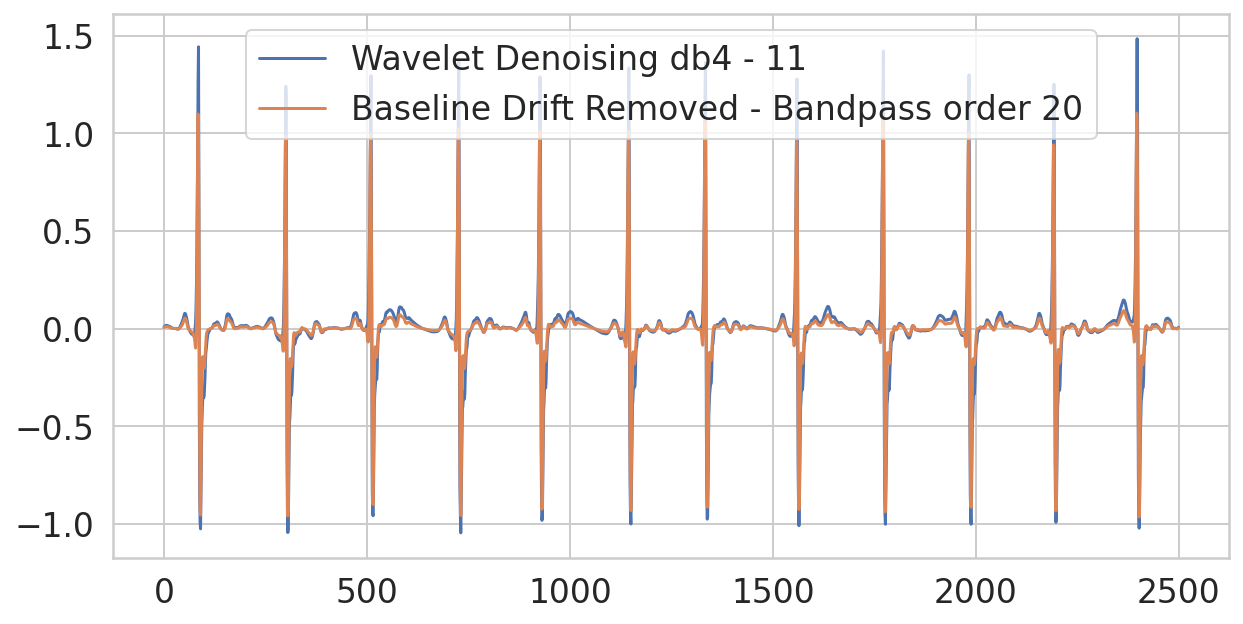

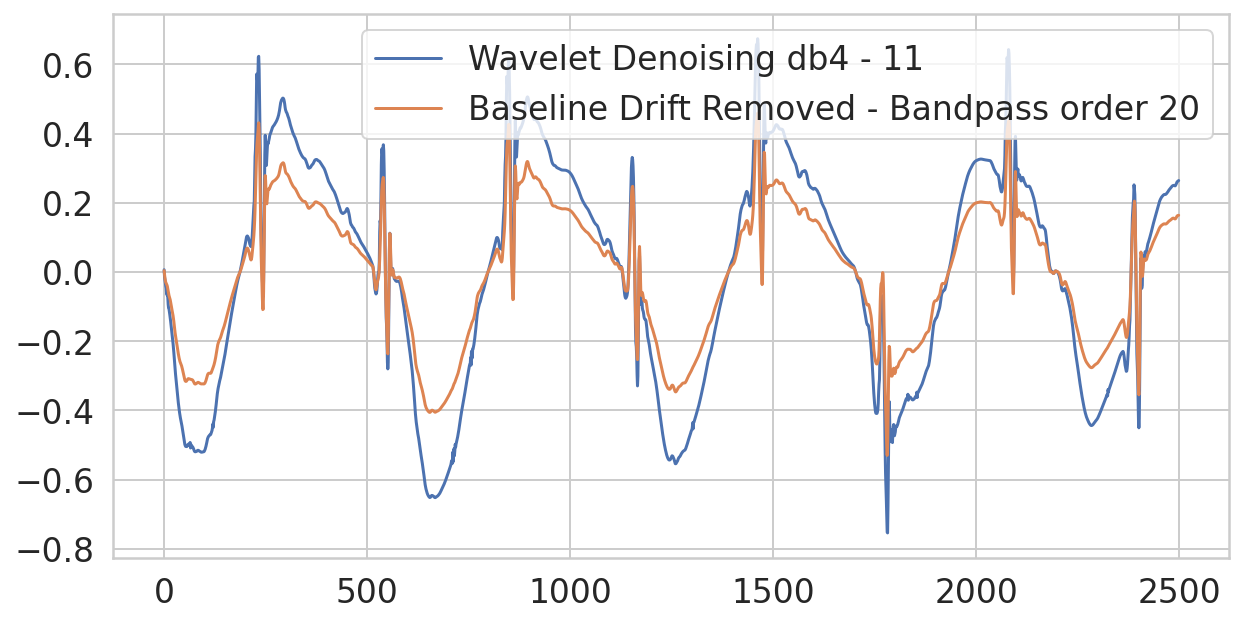

In [7]:
from biosppy.signals.tools import filter_signal

order = int(20)

x_train_nodrift = np.zeros(x_train_denoised.shape)
for s in range(x_train_denoised.shape[0]):
    for der in range(x_train_denoised.shape[-1]):
        x_train_nodrift[s, :, der], _, _ = filter_signal(signal=x_train_denoised[s, :, der], ftype="FIR", band="bandpass",
                                                 order=order, frequency=[3, 40],
                                                 sampling_rate=sampling_rate)
        
x_test_nodrift = np.zeros(x_test_denoised.shape)
for s in range(x_test_denoised.shape[0]):
    for der in range(x_test_denoised.shape[-1]):
        x_test_nodrift[s, :, der], _, _ = filter_signal(signal=x_test_denoised[s, :, der], ftype="FIR", band="bandpass",
                                                 order=order, frequency=[2.5, 45],
                                                 sampling_rate=sampling_rate)

sns.lineplot(data=x_train_denoised[0, :, 11], label='Wavelet Denoising db4 - {}'.format(level))
sns.lineplot(data=x_train_nodrift[0, :, 11], label='Baseline Drift Removed - Bandpass order {}'. format(order))
plt.show();
sns.lineplot(data=x_test_denoised[2, :, 11], label='Wavelet Denoising db4 - {}'.format(level))
sns.lineplot(data=x_test_nodrift[2, :, 11], label='Baseline Drift Removed - Bandpass order {}'. format(order))
plt.show();

Drift seems correctly removed. The signal seems centered and I don't think the order is too high since I do not see strange artifacts on the waves

For normalization I think for the moment I would juste use a z-score standardasization since I already found good results in conjunction with supervised models in other applications (and the distributions should be gaussian). Results of standardization seems ok. I will try out min-max normalization if training is not satisfying. I might normalize the signal based on global or by sample statitics. I will start with a by sample statistics and check results.

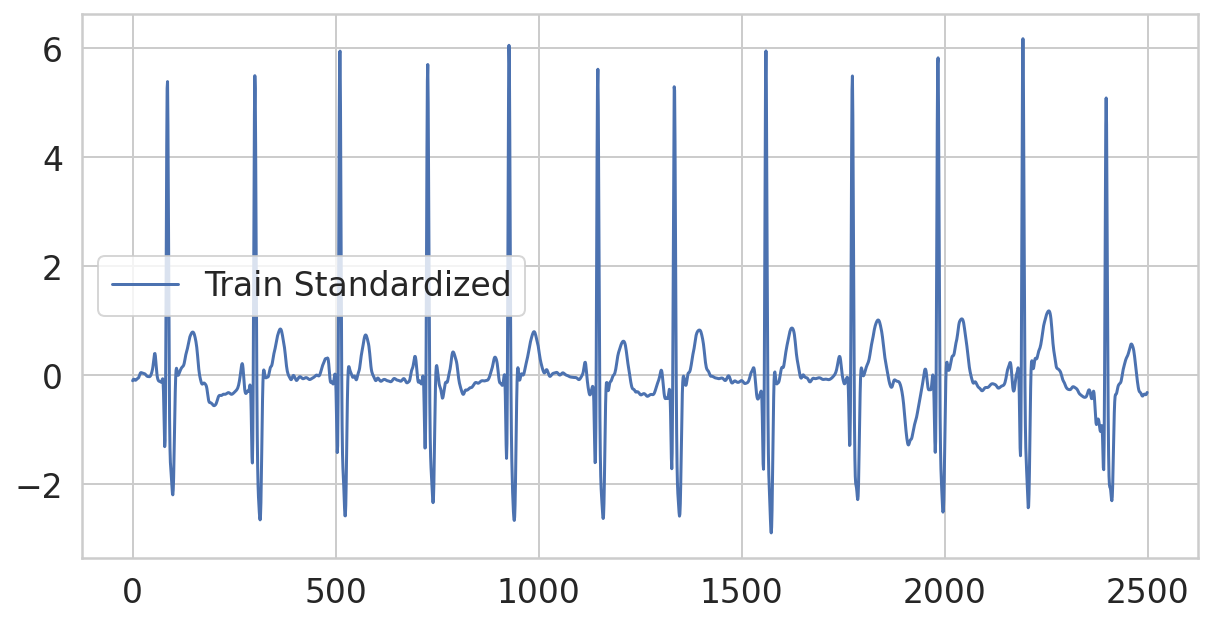

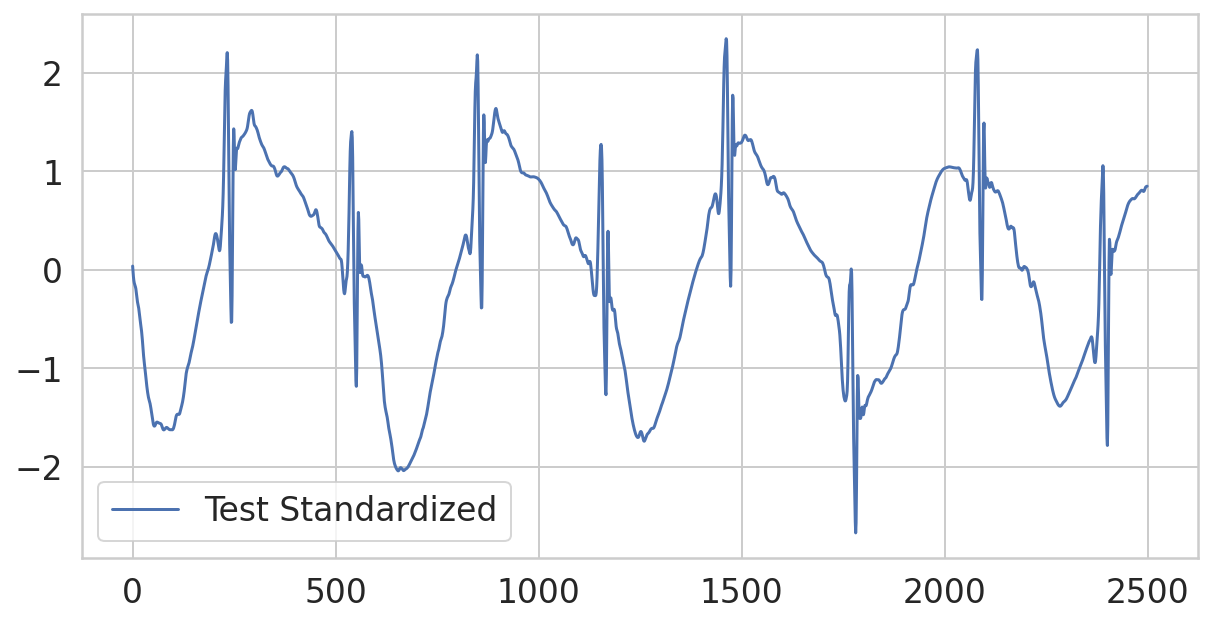

In [8]:
def z_score_norm(x):
    mean = np.mean(x)
    std = np.std(x)
    if std > 0:
        x = (x - mean) / std
    else:
        x *= 0.
    return x

x_train_centered = np.zeros(x_train_denoised.shape)
for s in range(x_train_nodrift.shape[0]):
    for der in range(x_train_nodrift.shape[-1]):
        x_train_centered[s, :, der] = z_score_norm(x_train_nodrift[s, :, der])
        
x_test_centered = np.zeros(x_test_denoised.shape)
for s in range(x_test_nodrift.shape[0]):
    for der in range(x_test_nodrift.shape[-1]):
        x_test_centered[s, :, der] = z_score_norm(x_test_nodrift[s, :, der])
        
sns.lineplot(data=x_train_centered[0, :, 0], label='Train Standardized')
plt.show();

sns.lineplot(data=x_test_centered[2, :, 11], label='Test Standardized')
plt.show();

In order to supervise the models I will need to split the dataset into training and validation. I guess a 80% / 20% should be OK. It may be usefeull to prepare multiple folds to cross validate the results. I don't have a lot of data so I might also use the folds to do some ensemble learning as the last step in order to fully exploits all samples available. I will define the model, fix the hyperparameters and train the same model 5 times on different folds. The result will be given by the weighted mean of each trained model. To have an ensemble that generalise well I can prepare the folds using the ground truth labels for stratification.

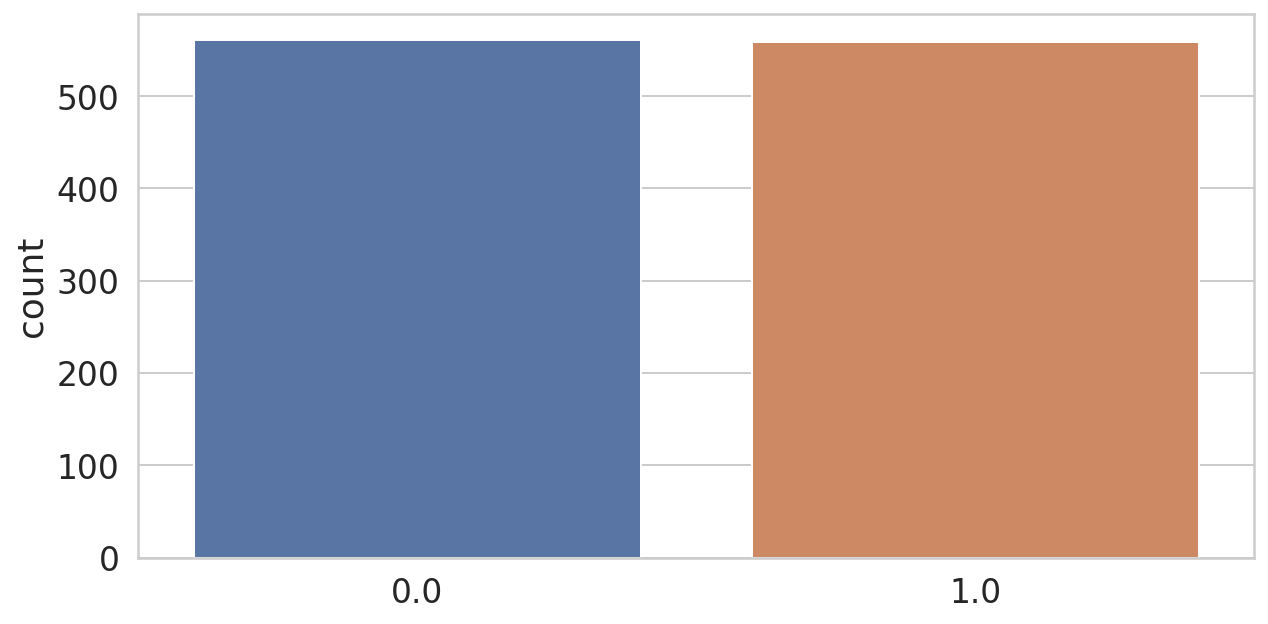

In [9]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
skf.get_n_splits(x_train_centered, y_train_raw)

train_folds = []
val_folds = []
for train_index, test_index in skf.split(x_train_centered, y_train_raw):
    train_folds.append((x_train_centered[train_index], y_train_raw[train_index]))
    val_folds.append((x_train_centered[test_index],  y_train_raw[test_index]))

train_ds_fold0 = train_folds[0]
val_ds_fold0 = val_folds[0]

sns.countplot(x=train_ds_fold0[1])
plt.show();

Stratification is correct.
For the moment I will only work with only the first fold in order to find a working architecture. Data are ready.

## Model  Selection and Training

A baseline for binary classification might be achieved with a support vector machine or a random forest classifier. These approaches might work but I do not expect good performances for higher dimensional data. I will need to flatten the leads dimensions in order to have a series of 1D arrays of length timestamp x leads. I t is safe to assume the classification problem is not linearly separable so I will try a svm with a non linear kernel and a rf since it should be fast to compute.

In [10]:
from sklearn.svm import NuSVC

svm = NuSVC()
svm.fit(np.reshape(train_ds_fold0[0], 
                   (train_ds_fold0[0].shape[0], train_ds_fold0[0].shape[1]*train_ds_fold0[0].shape[2])
                  ), train_ds_fold0[1])
acc = svm.score(np.reshape(val_ds_fold0[0],
                           (val_ds_fold0[0].shape[0], val_ds_fold0[0].shape[1]*val_ds_fold0[0].shape[2])
                           ), val_ds_fold0[1])

print('SVM mean accuracy score: {:.2%}'.format(acc))

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(np.reshape(train_ds_fold0[0], 
                   (train_ds_fold0[0].shape[0], train_ds_fold0[0].shape[1]*train_ds_fold0[0].shape[2])
                  ), train_ds_fold0[1])
acc = rf.score(np.reshape(val_ds_fold0[0],
                           (val_ds_fold0[0].shape[0], val_ds_fold0[0].shape[1]*val_ds_fold0[0].shape[2])
                           ), val_ds_fold0[1])

print('Random Forest mean accuracy score: {:.2%}'.format(acc))

NuSVC()

SVM mean accuracy score: 55.00%


RandomForestClassifier()

Random Forest mean accuracy score: 69.29%


ML algorithms reach a mean accuracy of around 60%. I am quite confident I can do better using DL and neural network.

In order to properly consider the third dimension I think a deep neural network should be the way to go. For time series analysis my options would be using recurrent neural network, convolutional neural network or transformers. I guess transformers might be too much for the task and the limited amount of data available for training. Since the third dimensions is not a time feature but a signal feature I am more inclided to implemented a CNN based model using 1-dimensional convolutions. The data are already in the good format since I have timesteps x features. I will start implemnting a base convolutional network and I will add complexity if I obtain some results. It might be interesting to combine convolution and lstm layers. 

For the deep learning framework I will use Tensorflow 2.8. Notebook can work on gpu using memory growth strategy. Tensorboard logs are stored in the ./tf_logs directory.The following cell is just for standard configuration.

In [11]:
# Tensorflow 2.x standard import + tensorboard
from packaging import version
import tensorflow as tf
print("TensorFlow version: {}".format(tf.__version__))
assert version.parse(tf.__version__).release[0] >= 2, "This notebook requires TensorFlow 2.0 or above."
%load_ext tensorboard
from tensorboard.plugins.hparams import api as hp

# GPU accelerated processing if available
gpu_list = tf.config.list_physical_devices('GPU')
print("GPUs Available:")
if gpu_list:
    try:
        for gpu in gpu_list:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpu_list), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)
else:
    print('None')

# Debugging
debug_mode = False # Reminder to myself: set to false before sending 
tf.config.run_functions_eagerly(debug_mode)
if debug_mode:
    tf.data.experimental.enable_debug_mode()
print("Eager execution: {}".format(tf.executing_eagerly()))

# Empty logs and cache
!rm -rf ./tf_logs/ 
tf.keras.backend.clear_session()

TensorFlow version: 2.8.0
GPUs Available:
1 Physical GPUs, 1 Logical GPUs
Eager execution: True


For a first try I will build a base CNN model and I will see if it has some training capabilities. In order to see if the model learns something I can just check if I manager to overfit it to training data, I will think about optimization if I found a suitable architecture. A first network could be conv -> pooling -> dense -> classification. I might create a conv layer composed of a conv1d+batchnorm+activation and an eventual dropout to improve generalisation. I will just use 1 convolutional layer to start.

For the hyperparameters.

- 50 epochs should be enough to overfit the model
- For the bartch size I do not want to start too high as it might just flatten out performances. I will put 16 for now and willl do a grid search after if I got the time.
- I  always got good performance with 2D and 3D CNN using Adam optimizer. I can start with an high lr just to see what happens and to optimize it along with the batch size

In [12]:
epochs = 50
batch_size = 16
lr = 1e-2

For the dataloader I am intered in reshuffling at each interation the training dataset and I dont care if the batch are not presented in a deterministic order. both dataset can be prefetched and cached for performance

In [13]:
train_ds = tf.data.Dataset.from_tensor_slices(train_ds_fold0)
val_ds = tf.data.Dataset.from_tensor_slices(val_ds_fold0)

train_ds = train_ds.batch(batch_size, num_parallel_calls=tf.data.experimental.AUTOTUNE,
                          deterministic=False
                         ).prefetch(tf.data.experimental.AUTOTUNE).cache().shuffle(len(train_ds),
                                                                                   reshuffle_each_iteration=True)
val_ds = val_ds.batch(batch_size, num_parallel_calls=tf.data.experimental.AUTOTUNE,
                      deterministic=True
                     ).prefetch(tf.data.experimental.AUTOTUNE).cache()

The most delicate hyperparameters I should decide how to fix are the number of convolutional filters and the kernel size. For the kernel size I need to define  how many neighboors I want to include in the convolution. Considering that each timestep corresponds to 1/250 = 4ms I could take a 100ms window using a kernel_size=25. 100ms should represent a normal interval for a QRS complex (looked up on wiki, hopefully they're right...). I am not quite sure yet how many filters I should use, I guess I can start with 32/64 and ramp up if necessary, I will definetively add more filters if the model underfit.

I inserted a batchnorm layer to guide training. I expect it to behave correctly but I might remove it if I see too much smoothing.

The only activation functions I really consider is the relu family. I dont want to introduce complexity with a parametric relu but I could consider a leaky relu, I dont expect an huge improvements of performance with a lrelu but might try it if I got time.

Global pooling seems the good options to flatten the results and reduce complexity at the same time.

For the other hyperparameters I prefer to use an he initialization over glorot when using CNN but it shouldnt change much tbh. 

The dense layer has obsiously only two neurons since it is a binary classification problem. I am not sure yet if I want to add more hidden dense layers, I think that if I want to increase the model complexity I should just add more convolution to extract more important signal features.

I use a softmax activation function but I could also use a sigmoid and impose a threshold for classification. Crossentropy should be the correct loss function to optimize but I might explore more complex loss if necessary, I use its sparse version since my labels are not in a one-hot formulation.

In [14]:
cnn_model = tf.keras.Sequential()
cnn_model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=25, padding='same', kernel_initializer='he_normal',
                                     activation=None, input_shape=(2500, 12)))
cnn_model.add(tf.keras.layers.BatchNormalization(axis=-1))
cnn_model.add(tf.keras.layers.LeakyReLU())
cnn_model.add(tf.keras.layers.GlobalAveragePooling1D())
cnn_model.add(tf.keras.layers.Dense(2, activation='softmax'))

cnn_model.compile(optimizer=tf.keras.optimizers.Adam(lr),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy',],)

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2500, 32)          9632      
                                                                 
 batch_normalization (BatchN  (None, 2500, 32)         128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 2500, 32)          0         
                                                                 
 global_average_pooling1d (G  (None, 32)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 2)                 66        
                                                                 
Total params: 9,826
Trainable params: 9,762
Non-trainabl

I usually use tensorboard to follow the training curves and distributions. If you want to check training logs outside this notebook you should be able to find the tensoboard window in localhost at port 6006

In [15]:
%tensorboard --logdir ./tf_logs --host 0.0.0.0

First training:

In [16]:
history = cnn_model.fit(x=train_ds, validation_data=val_ds,
                        batch_size=batch_size, epochs=epochs, verbose=1,
                        callbacks=[tf.keras.callbacks.TensorBoard(log_dir='./tf_logs/baseCNN',
                                                                  histogram_freq=1, update_freq='batch')],
          use_multiprocessing=True)

Epoch 1/50
70/70 [==============================] - 2s 5ms/step - loss: 0.5469 - accuracy: 0.7437 - val_loss: 0.3920 - val_accuracy: 0.8393
Epoch 2/50
70/70 [==============================] - 0s 3ms/step - loss: 0.4123 - accuracy: 0.8250 - val_loss: 0.2558 - val_accuracy: 0.9321
Epoch 3/50
70/70 [==============================] - 0s 3ms/step - loss: 0.3526 - accuracy: 0.8473 - val_loss: 0.2530 - val_accuracy: 0.9179
Epoch 4/50
70/70 [==============================] - 0s 3ms/step - loss: 0.3029 - accuracy: 0.8777 - val_loss: 0.1970 - val_accuracy: 0.9357
Epoch 5/50
70/70 [==============================] - 0s 3ms/step - loss: 0.2862 - accuracy: 0.8875 - val_loss: 0.2240 - val_accuracy: 0.9214
Epoch 6/50
70/70 [==============================] - 0s 3ms/step - loss: 0.2652 - accuracy: 0.8946 - val_loss: 0.2057 - val_accuracy: 0.9357
Epoch 7/50
70/70 [==============================] - 0s 3ms/step - loss: 0.2425 - accuracy: 0.9089 - val_loss: 0.1834 - val_accuracy: 0.9357
Epoch 8/50
70/70 [==

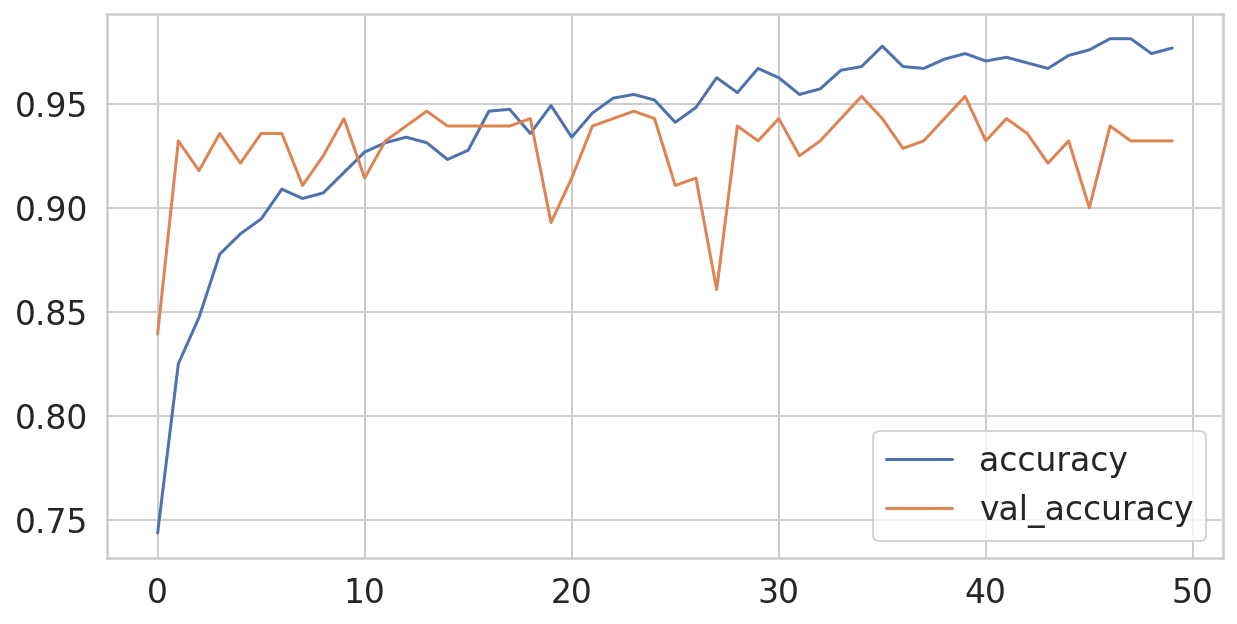

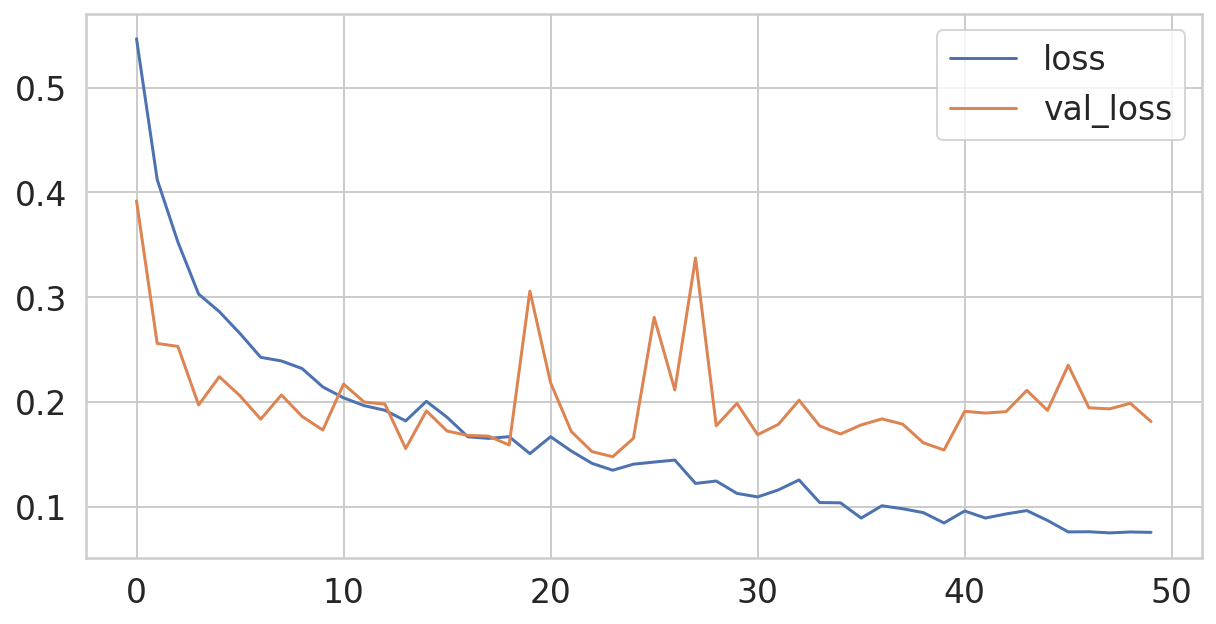

In [17]:
sns.lineplot(data=history.history['accuracy'], label='accuracy')
sns.lineplot(data=history.history['val_accuracy'], label='val_accuracy')
plt.show();
sns.lineplot(data=history.history['loss'], label='loss')
sns.lineplot(data=history.history['val_loss'], label='val_loss')
plt.show();

The training actually seems pretty stable and it seems it is learning correctly. For a first try we see a 30% accuracy increase over the random forest model. Let's see if it work better with better hyperparameters.  I may try to increase the batch size to make the training loop mor stable, lowering the learning rate to avoid overfitting and add a dropout layer to improve generalization.

In [18]:
batch_size = 128
lr = 1e-3

train_ds = tf.data.Dataset.from_tensor_slices(train_ds_fold0)
val_ds = tf.data.Dataset.from_tensor_slices(val_ds_fold0)

train_ds = train_ds.batch(batch_size, num_parallel_calls=tf.data.experimental.AUTOTUNE,
                          deterministic=False
                         ).prefetch(tf.data.experimental.AUTOTUNE).cache().shuffle(len(train_ds),
                                                                                   reshuffle_each_iteration=True)
val_ds = val_ds.batch(batch_size, num_parallel_calls=tf.data.experimental.AUTOTUNE,
                      deterministic=True
                     ).prefetch(tf.data.experimental.AUTOTUNE).cache()

cnn_model = tf.keras.Sequential()
cnn_model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=25, padding='same', kernel_initializer='he_normal',
                                     activation=None, input_shape=(2500, 12)))
cnn_model.add(tf.keras.layers.BatchNormalization(axis=-1))
cnn_model.add(tf.keras.layers.LeakyReLU())
cnn_model.add(tf.keras.layers.Dropout(0.5))
cnn_model.add(tf.keras.layers.GlobalAveragePooling1D())
cnn_model.add(tf.keras.layers.Dense(2, activation='softmax'))

cnn_model.compile(optimizer=tf.keras.optimizers.Adam(lr),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy',],)

cnn_model.summary()

history = cnn_model.fit(x=train_ds, validation_data=val_ds,
                        batch_size=batch_size, epochs=epochs, verbose=1,
                        callbacks=[tf.keras.callbacks.TensorBoard(log_dir='./tf_logs/baseCNN_batch128_lr1e-3',
                                                                  histogram_freq=1, update_freq='batch')],
          use_multiprocessing=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 2500, 32)          9632      
                                                                 
 batch_normalization_1 (Batc  (None, 2500, 32)         128       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 2500, 32)          0         
                                                                 
 dropout (Dropout)           (None, 2500, 32)          0         
                                                                 
 global_average_pooling1d_1   (None, 32)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_1 (Dense)             (None, 2)                

Epoch 50/50
9/9 [==============================] - 0s 19ms/step - loss: 0.2485 - accuracy: 0.9232 - val_loss: 0.2490 - val_accuracy: 0.9286


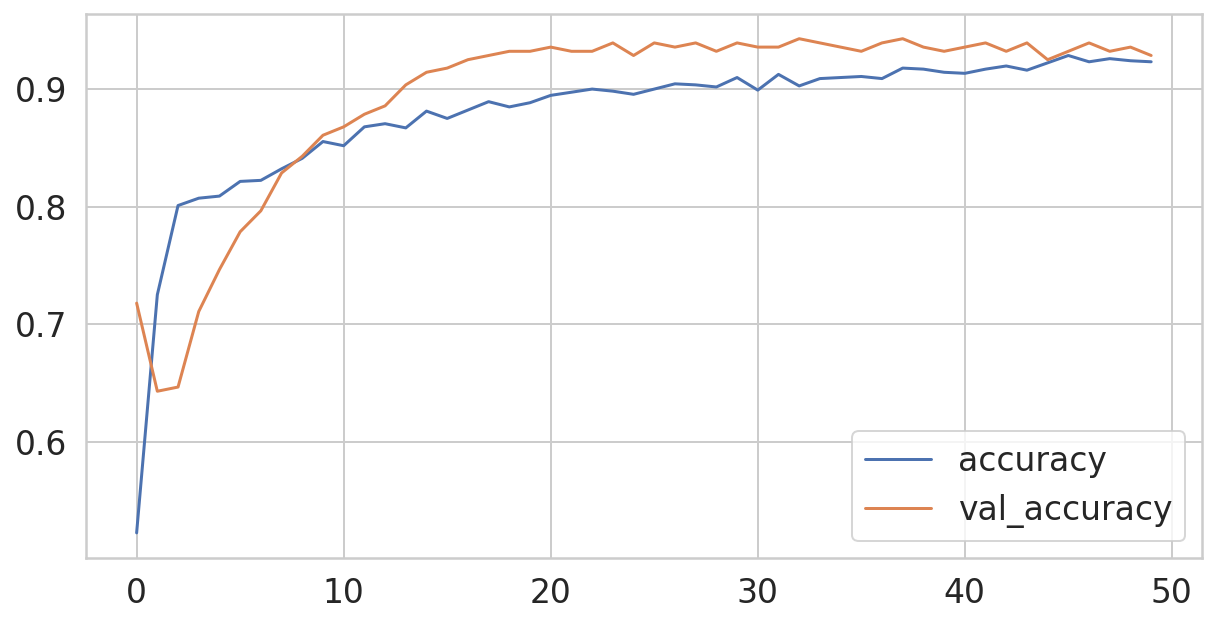

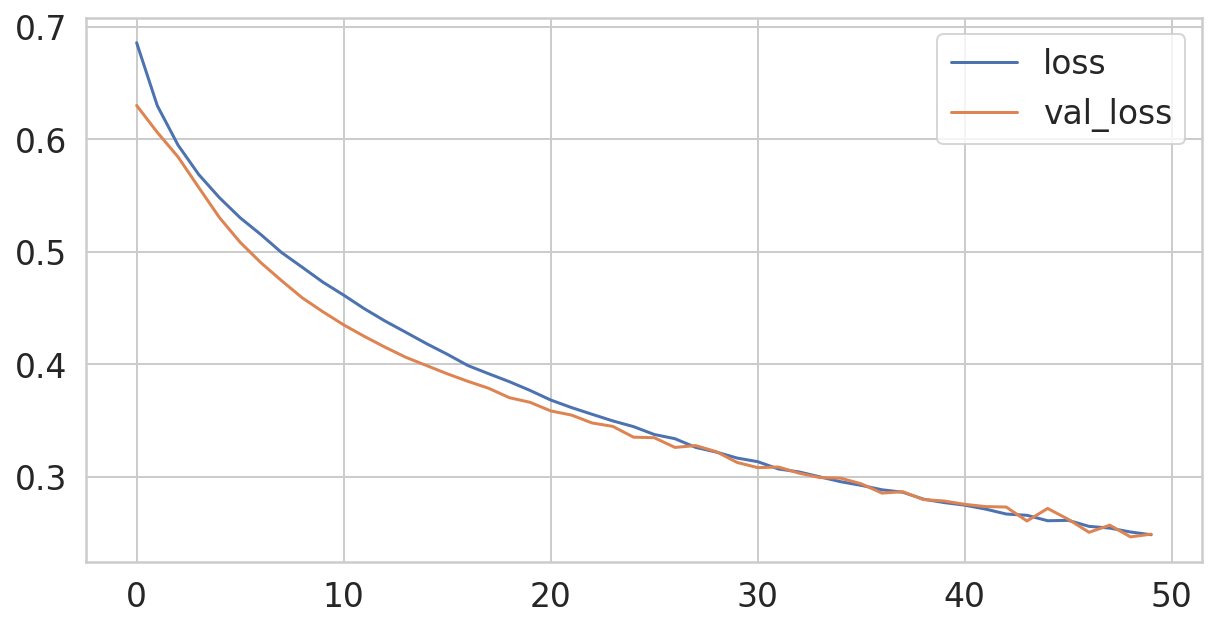

In [19]:
sns.lineplot(data=history.history['accuracy'], label='accuracy')
sns.lineplot(data=history.history['val_accuracy'], label='val_accuracy')
plt.show();
sns.lineplot(data=history.history['loss'], label='loss')
sns.lineplot(data=history.history['val_loss'], label='val_loss')
plt.show();

I will explore if increasing the number of parameters improves performance (it might if the additional conv layers can extract meaningful features). I might repeat two-three times the conv-batch-activation module without chaning the other params. I will definitely tune down the lr to provide a more stable training loop.

In [20]:
class ConvBatchRelu(tf.keras.layers.Layer):
    def __init__(self, filters=128, kernel_size=25, inshape=None, name='ConvBatchRelu', **kwargs):
        super(ConvBatchRelu, self).__init__(name=name, **kwargs)
        if inshape:
            self.conv = tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, padding='same',
                                               kernel_initializer='he_normal', activation=None,
                                               input_shape=inshape)
        else:
            self.conv = tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, padding='same',
                                               kernel_initializer='he_normal', activation=None)
        self.batch = tf.keras.layers.BatchNormalization(axis=-1)
        self.act = tf.keras.layers.ReLU()
        self.drop = tf.keras.layers.Dropout(0.5)
                
    @tf.function
    def call(self, inputs, training=None, **kwargs):
        x = self.conv(inputs, training=training)
        x = self.batch(x, training=training)
        x = self.act(x, training=training)
        return self.drop(x)


class CNN1D(tf.keras.models.Model):
    def __init__(self, n_convs=2, base_filters=128, kernel_size = 25, n_class=2, inshape=(2500, 12)):
        super(CNN1D, self).__init__(self)
        self.convs = [ConvBatchRelu(base_filters, kernel_size, inshape) if i==0 
                      else ConvBatchRelu(base_filters*(2**i), kernel_size) for i in range(n_convs)]
        self.p = tf.keras.layers.GlobalAveragePooling1D()
        self.dense = tf.keras.layers.Dense(n_class, activation='softmax')
        
    @tf.function
    def call(self, inputs, training=None, **kwargs):
        x = inputs
        for c in self.convs:
            x = c(x, training=training)
        x = self.p(x, training=training)
        x = self.dense(x, training=training)
        return x
    
lr = 1e-4
n_convs = [2]
for n in n_convs:
    cnn_deeper = CNN1D(n)

    cnn_deeper.compile(optimizer=tf.keras.optimizers.Adam(lr),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy',])

    history = cnn_deeper.fit(x=train_ds, validation_data=val_ds,
                             batch_size=batch_size, epochs=epochs, verbose=2, 
                             callbacks=[tf.keras.callbacks.TensorBoard(log_dir='./tf_logs/{}_convs_CNN'.format(n),
                                                                       histogram_freq=1, update_freq='batch')],
                             use_multiprocessing=True)

Epoch 1/50
9/9 - 3s - loss: 0.6729 - accuracy: 0.5536 - val_loss: 0.5928 - val_accuracy: 0.6786 - 3s/epoch - 315ms/step
Epoch 2/50
9/9 - 1s - loss: 0.5734 - accuracy: 0.7661 - val_loss: 0.5002 - val_accuracy: 0.7821 - 799ms/epoch - 89ms/step
Epoch 3/50
9/9 - 1s - loss: 0.5141 - accuracy: 0.7920 - val_loss: 0.4946 - val_accuracy: 0.7571 - 797ms/epoch - 89ms/step
Epoch 4/50
9/9 - 1s - loss: 0.4702 - accuracy: 0.8143 - val_loss: 0.6146 - val_accuracy: 0.7071 - 804ms/epoch - 89ms/step
Epoch 5/50
9/9 - 1s - loss: 0.4368 - accuracy: 0.8313 - val_loss: 0.7399 - val_accuracy: 0.6429 - 800ms/epoch - 89ms/step
Epoch 6/50
9/9 - 1s - loss: 0.4074 - accuracy: 0.8429 - val_loss: 0.6628 - val_accuracy: 0.6786 - 799ms/epoch - 89ms/step
Epoch 7/50
9/9 - 1s - loss: 0.3822 - accuracy: 0.8518 - val_loss: 0.6448 - val_accuracy: 0.6750 - 802ms/epoch - 89ms/step
Epoch 8/50
9/9 - 1s - loss: 0.3608 - accuracy: 0.8625 - val_loss: 0.5380 - val_accuracy: 0.7357 - 836ms/epoch - 93ms/step
Epoch 9/50
9/9 - 1s - loss

Model: "cnn1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ConvBatchRelu (ConvBatchRel  multiple                 39040     
 u)                                                              
                                                                 
 ConvBatchRelu (ConvBatchRel  multiple                 820480    
 u)                                                              
                                                                 
 global_average_pooling1d_2   multiple                 0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             multiple                  514       
                                                                 
Total params: 860,034
Trainable params: 859,266
Non-trainable params: 768
_____________________________________________________

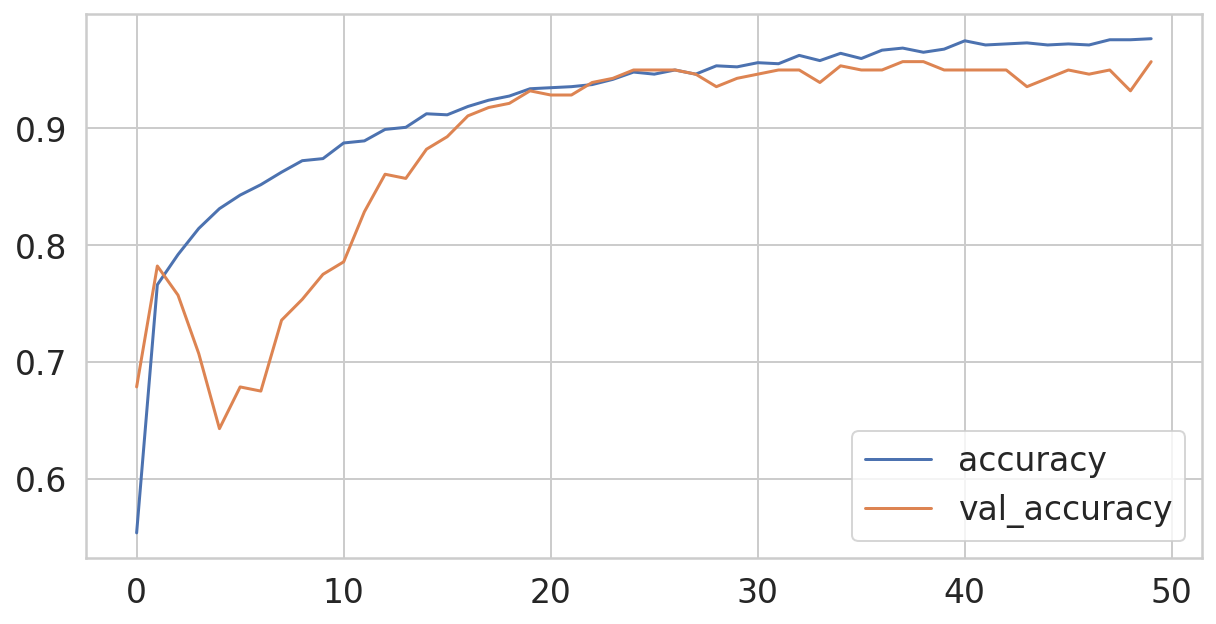

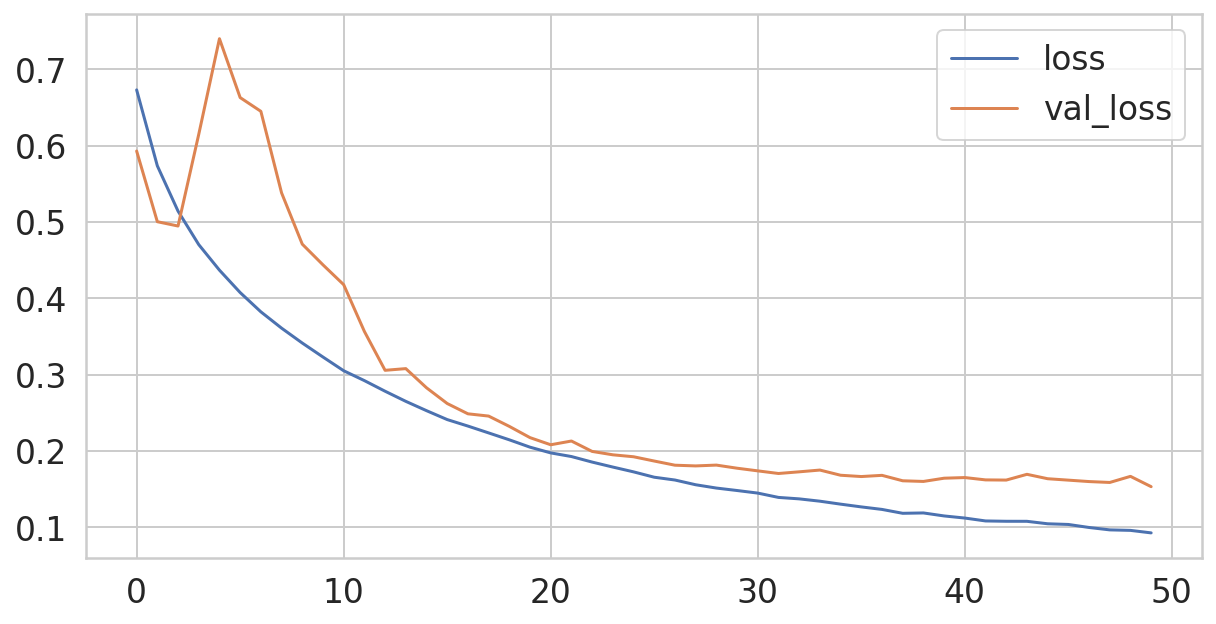

In [21]:
cnn_deeper.summary()

sns.lineplot(data=history.history['accuracy'], label='accuracy')
sns.lineplot(data=history.history['val_accuracy'], label='val_accuracy')
plt.show();
sns.lineplot(data=history.history['loss'], label='loss')
sns.lineplot(data=history.history['val_loss'], label='val_loss')
plt.show();

The training seems correct but adding too many layers just brought instability.
The additional complexity causes some overfit on the training data. I think I will keep the model with one convolution. Let's just try to add complexity adding some filters (64) and maybe use a larger kernel.

In [22]:
lr = 1e-3

cnn_model = tf.keras.Sequential()
cnn_model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=50, padding='same', kernel_initializer='he_normal',
                                     activation=None, input_shape=(2500, 12)))
cnn_model.add(tf.keras.layers.BatchNormalization(axis=-1))
cnn_model.add(tf.keras.layers.LeakyReLU())
cnn_model.add(tf.keras.layers.Dropout(0.5))
cnn_model.add(tf.keras.layers.GlobalAveragePooling1D())
cnn_model.add(tf.keras.layers.Dense(2, activation='softmax'))

cnn_model.compile(optimizer=tf.keras.optimizers.Adam(lr),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy',],)

cnn_model.summary()

history = cnn_model.fit(x=train_ds, validation_data=val_ds,
                        batch_size=batch_size, epochs=epochs, verbose=1,
                        callbacks=[tf.keras.callbacks.TensorBoard(log_dir='./tf_logs/baseCNN__batch128_lr1e-3_64filt_50ker',
                                                                  histogram_freq=1, update_freq='batch')],
          use_multiprocessing=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 2500, 64)          38464     
                                                                 
 batch_normalization_4 (Batc  (None, 2500, 64)         256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 2500, 64)          0         
                                                                 
 dropout_3 (Dropout)         (None, 2500, 64)          0         
                                                                 
 global_average_pooling1d_3   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_3 (Dense)             (None, 2)                

Epoch 50/50
9/9 [==============================] - 0s 25ms/step - loss: 0.1711 - accuracy: 0.9580 - val_loss: 0.1830 - val_accuracy: 0.9429


Model: "cnn1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ConvBatchRelu (ConvBatchRel  multiple                 39040     
 u)                                                              
                                                                 
 ConvBatchRelu (ConvBatchRel  multiple                 820480    
 u)                                                              
                                                                 
 global_average_pooling1d_2   multiple                 0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             multiple                  514       
                                                                 
Total params: 860,034
Trainable params: 859,266
Non-trainable params: 768
_____________________________________________________

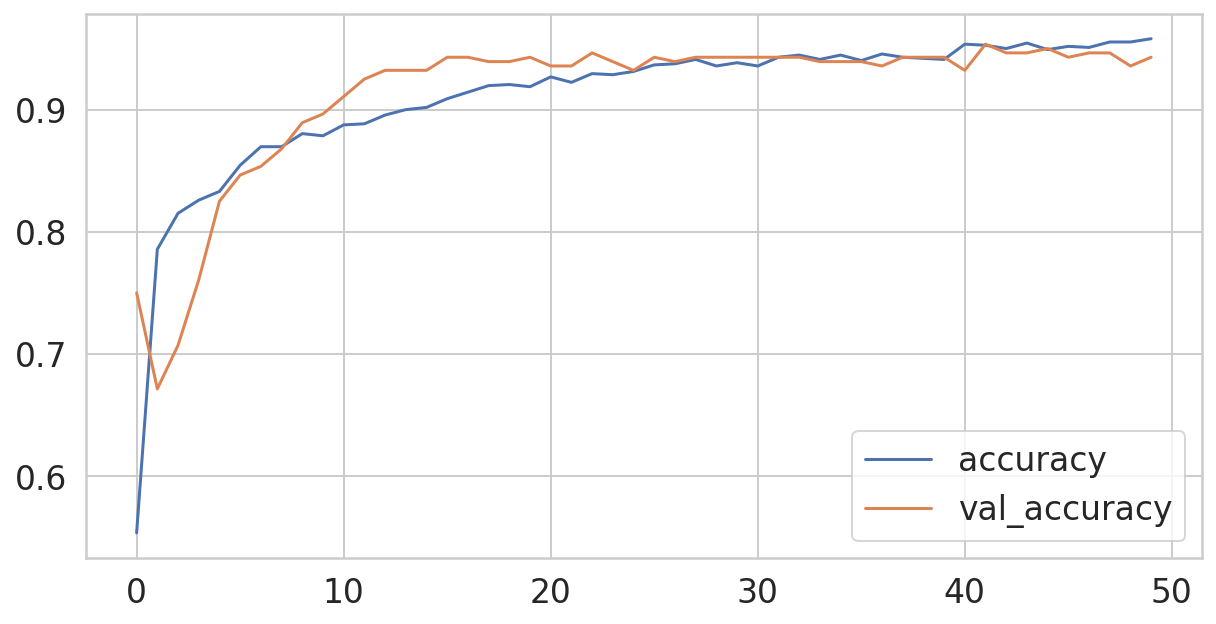

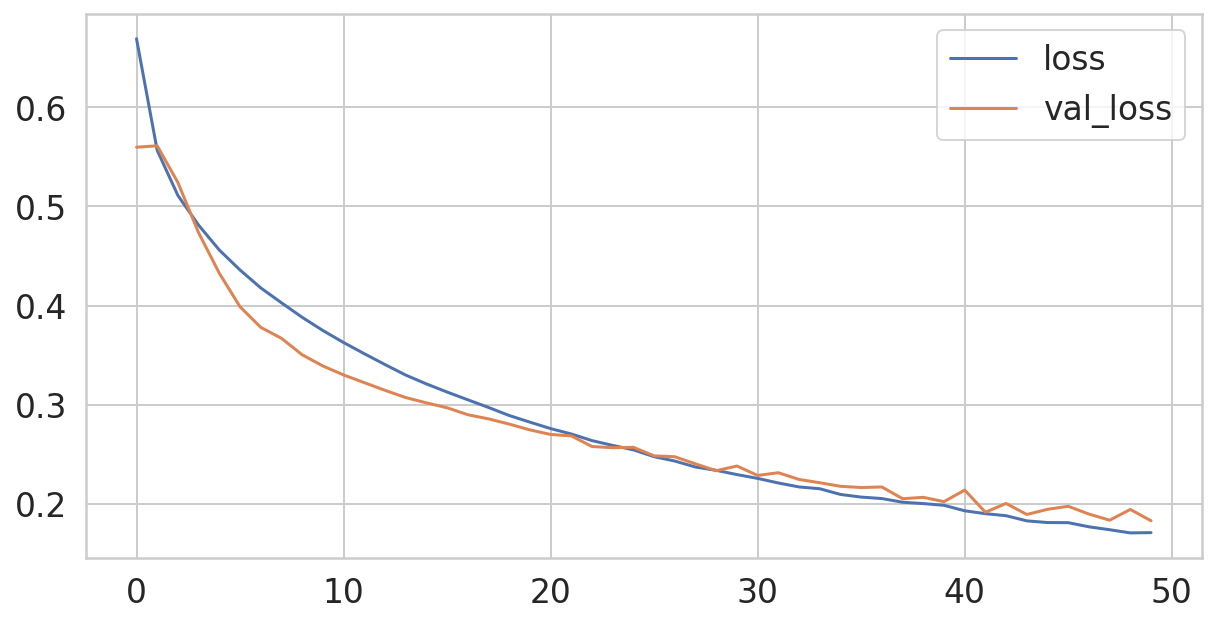

In [23]:
cnn_deeper.summary()

sns.lineplot(data=history.history['accuracy'], label='accuracy')
sns.lineplot(data=history.history['val_accuracy'], label='val_accuracy')
plt.show();
sns.lineplot(data=history.history['loss'], label='loss')
sns.lineplot(data=history.history['val_loss'], label='val_loss')
plt.show();

Results are defintevely comparable. I may stick with 32 filters and a kernel size of 50 since they reduce a little bit the overfit of the model. The final model will thus be composed by one series of conv->batchnorm->relu->dropout. with 32 filters, kernel=25, a batch of 128. It may be interesting to do a proper hyperparameters optimization with the tensorboard hparams plugins since I might get better results with more layers and a lower lr to reduce overfitting.

In [24]:
epochs = 80

final_model = tf.keras.Sequential()
final_model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=50, padding='same', kernel_initializer='he_normal',
                                     activation=None, input_shape=(2500, 12)))
final_model.add(tf.keras.layers.BatchNormalization(axis=-1))
final_model.add(tf.keras.layers.LeakyReLU())
final_model.add(tf.keras.layers.Dropout(0.5))
final_model.add(tf.keras.layers.GlobalAveragePooling1D())
final_model.add(tf.keras.layers.Dense(2, activation='softmax'))

final_model.compile(optimizer=tf.keras.optimizers.Adam(lr),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy',],)

final_model.summary()

history = final_model.fit(x=train_ds, validation_data=val_ds,
                        batch_size=batch_size, epochs=epochs, verbose=1,
                        callbacks=[tf.keras.callbacks.TensorBoard(log_dir='./tf_logs/final_model',
                                                                  histogram_freq=1, update_freq='batch')],
          use_multiprocessing=True)



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 2500, 32)          19232     
                                                                 
 batch_normalization_5 (Batc  (None, 2500, 32)         128       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 2500, 32)          0         
                                                                 
 dropout_4 (Dropout)         (None, 2500, 32)          0         
                                                                 
 global_average_pooling1d_4   (None, 32)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_4 (Dense)             (None, 2)                

Epoch 50/80
9/9 [==============================] - 0s 21ms/step - loss: 0.2093 - accuracy: 0.9473 - val_loss: 0.2161 - val_accuracy: 0.9286
Epoch 51/80
9/9 [==============================] - 0s 21ms/step - loss: 0.2087 - accuracy: 0.9473 - val_loss: 0.2079 - val_accuracy: 0.9536
Epoch 52/80
9/9 [==============================] - 0s 21ms/step - loss: 0.2047 - accuracy: 0.9473 - val_loss: 0.2068 - val_accuracy: 0.9536
Epoch 53/80
9/9 [==============================] - 0s 21ms/step - loss: 0.2009 - accuracy: 0.9491 - val_loss: 0.2121 - val_accuracy: 0.9321
Epoch 54/80
9/9 [==============================] - 0s 21ms/step - loss: 0.1998 - accuracy: 0.9509 - val_loss: 0.2055 - val_accuracy: 0.9429
Epoch 55/80
9/9 [==============================] - 0s 21ms/step - loss: 0.2001 - accuracy: 0.9446 - val_loss: 0.2034 - val_accuracy: 0.9429
Epoch 56/80
9/9 [==============================] - 0s 20ms/step - loss: 0.1975 - accuracy: 0.9482 - val_loss: 0.2039 - val_accuracy: 0.9357
Epoch 57/80
9/9 [===

Overall the model behave quite well. Plotting the confusion matrix and some stats of the best model in order to better define its performances

Accuracy: 94.6% - Precision: 94.9% - Recall: 94.2%


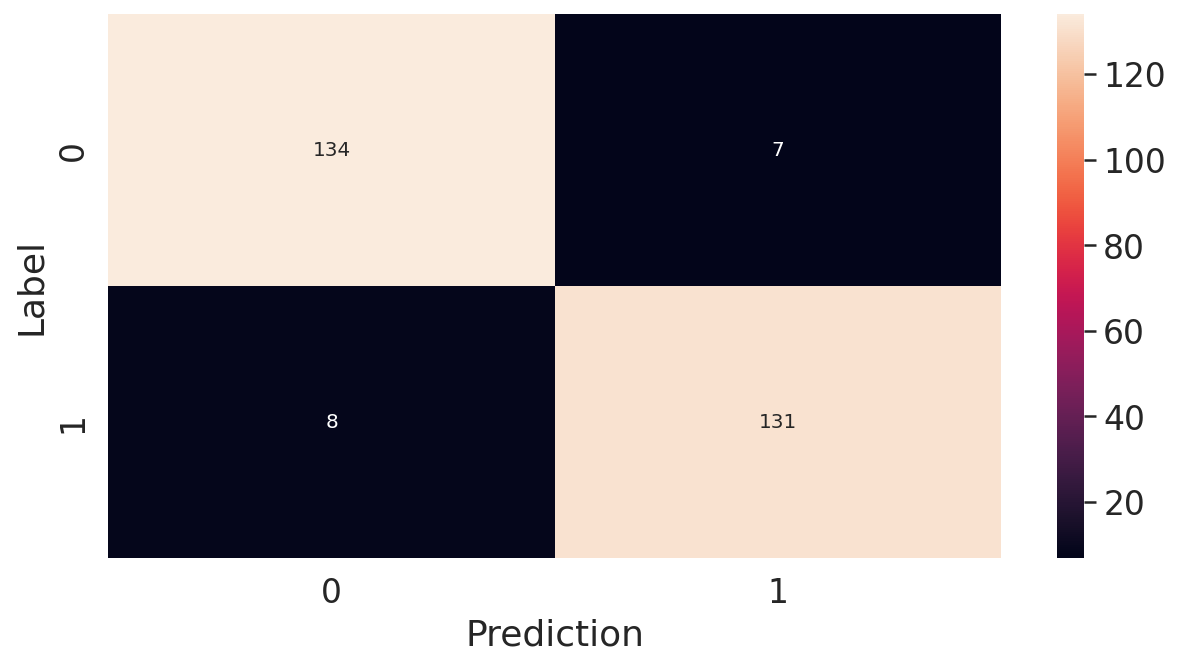

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

y_pred = np.argmax(final_model.predict(val_ds_fold0[0]), axis=1)
y_true = val_ds_fold0[1]

print('Accuracy: {:.1%} - Precision: {:.1%} - Recall: {:.1%}'.format(accuracy_score(y_true, y_pred),
                                                                     precision_score(y_true, y_pred),
                                                                     recall_score(y_true, y_pred)))

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
sns.heatmap(confusion_mtx,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show();

We observe an overall good accuracy with a precision and recall rate which are quite similar. If I had to maximise one of the two I would say that recall should be prioritized as in medical practice it is better to have a system which is able to predict all true positives with lower precision than having a precise system that is prone to miss imortant medical information

Adding an LSTM layer to exploit more temporal information should be interesting. It might be interesting to check if a robust loss such as the F1 score can better work in this case where there is a bit of class imbalance. I saw that creating more complex models did not improe the reuslts but it should be interesting to see if the the convolutional layer could be chnanged with a residual convolutional layer.

## Ensemble Strategy

I will now train different model, with fixed hyperparameters, on the different folds I prepared at the beginning. Checking the training curves on tensorboard I will be sure that the the results are valid and stable across folds and I will use all the models to do an ensemble of predictions.

In [26]:
models = []
for i, fold in enumerate(train_folds):
    train_ds = tf.data.Dataset.from_tensor_slices(fold)
    val_ds = tf.data.Dataset.from_tensor_slices(fold)

    train_ds = train_ds.batch(batch_size, num_parallel_calls=tf.data.experimental.AUTOTUNE,
                              deterministic=False
                             ).prefetch(tf.data.experimental.AUTOTUNE).cache().shuffle(len(train_ds),
                                                                                       reshuffle_each_iteration=True)
    val_ds = val_ds.batch(batch_size, num_parallel_calls=tf.data.experimental.AUTOTUNE,
                          deterministic=True
                         ).prefetch(tf.data.experimental.AUTOTUNE).cache()
    
    current_model = tf.keras.Sequential()
    current_model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=50, padding='same', kernel_initializer='he_normal',
                                         activation=None, input_shape=(2500, 12)))
    current_model.add(tf.keras.layers.BatchNormalization(axis=-1))
    current_model.add(tf.keras.layers.LeakyReLU())
    current_model.add(tf.keras.layers.Dropout(0.5))
    current_model.add(tf.keras.layers.GlobalAveragePooling1D())
    current_model.add(tf.keras.layers.Dense(2, activation='softmax'))

    current_model.compile(optimizer=tf.keras.optimizers.Adam(lr),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy',],)

    current_model.summary()

    history = current_model.fit(x=train_ds, validation_data=val_ds,
                            batch_size=batch_size, epochs=epochs, verbose=1,
                            callbacks=[tf.keras.callbacks.TensorBoard(log_dir='./tf_logs/final_model_fold{}'.format(i),
                                                                      histogram_freq=1, update_freq='batch')],
              use_multiprocessing=True)

    models.append(current_model)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 2500, 32)          19232     
                                                                 
 batch_normalization_6 (Batc  (None, 2500, 32)         128       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 2500, 32)          0         
                                                                 
 dropout_5 (Dropout)         (None, 2500, 32)          0         
                                                                 
 global_average_pooling1d_5   (None, 32)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_5 (Dense)             (None, 2)                

Epoch 50/80
9/9 [==============================] - 0s 36ms/step - loss: 0.2085 - accuracy: 0.9429 - val_loss: 0.2059 - val_accuracy: 0.9509
Epoch 51/80
9/9 [==============================] - 0s 37ms/step - loss: 0.2058 - accuracy: 0.9438 - val_loss: 0.2030 - val_accuracy: 0.9509
Epoch 52/80
9/9 [==============================] - 0s 36ms/step - loss: 0.2017 - accuracy: 0.9464 - val_loss: 0.1993 - val_accuracy: 0.9446
Epoch 53/80
9/9 [==============================] - 0s 36ms/step - loss: 0.2016 - accuracy: 0.9491 - val_loss: 0.1978 - val_accuracy: 0.9536
Epoch 54/80
9/9 [==============================] - 0s 37ms/step - loss: 0.1976 - accuracy: 0.9438 - val_loss: 0.1949 - val_accuracy: 0.9527
Epoch 55/80
9/9 [==============================] - 0s 37ms/step - loss: 0.1949 - accuracy: 0.9464 - val_loss: 0.1917 - val_accuracy: 0.9527
Epoch 56/80
9/9 [==============================] - 0s 37ms/step - loss: 0.1934 - accuracy: 0.9473 - val_loss: 0.1921 - val_accuracy: 0.9536
Epoch 57/80
9/9 [===

Epoch 19/80
9/9 [==============================] - 0s 36ms/step - loss: 0.3510 - accuracy: 0.8964 - val_loss: 0.3517 - val_accuracy: 0.9107
Epoch 20/80
9/9 [==============================] - 0s 36ms/step - loss: 0.3431 - accuracy: 0.9089 - val_loss: 0.3466 - val_accuracy: 0.9107
Epoch 21/80
9/9 [==============================] - 0s 37ms/step - loss: 0.3352 - accuracy: 0.9071 - val_loss: 0.3407 - val_accuracy: 0.9089
Epoch 22/80
9/9 [==============================] - 0s 37ms/step - loss: 0.3293 - accuracy: 0.9089 - val_loss: 0.3358 - val_accuracy: 0.9214
Epoch 23/80
9/9 [==============================] - 0s 36ms/step - loss: 0.3229 - accuracy: 0.9107 - val_loss: 0.3278 - val_accuracy: 0.9161
Epoch 24/80
9/9 [==============================] - 0s 37ms/step - loss: 0.3150 - accuracy: 0.9152 - val_loss: 0.3229 - val_accuracy: 0.9223
Epoch 25/80
9/9 [==============================] - 0s 36ms/step - loss: 0.3101 - accuracy: 0.9107 - val_loss: 0.3221 - val_accuracy: 0.9116
Epoch 26/80
9/9 [===

9/9 [==============================] - 0s 36ms/step - loss: 0.1644 - accuracy: 0.9545 - val_loss: 0.1588 - val_accuracy: 0.9509
Epoch 78/80
9/9 [==============================] - 0s 36ms/step - loss: 0.1650 - accuracy: 0.9554 - val_loss: 0.1584 - val_accuracy: 0.9589
Epoch 79/80
9/9 [==============================] - 0s 36ms/step - loss: 0.1635 - accuracy: 0.9545 - val_loss: 0.1564 - val_accuracy: 0.9563
Epoch 80/80
9/9 [==============================] - 0s 36ms/step - loss: 0.1615 - accuracy: 0.9527 - val_loss: 0.1548 - val_accuracy: 0.9580
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 2500, 32)          19232     
                                                                 
 batch_normalization_8 (Batc  (None, 2500, 32)         128       
 hNormalization)                                                 
                                  

9/9 [==============================] - 0s 36ms/step - loss: 0.2282 - accuracy: 0.9348 - val_loss: 0.2285 - val_accuracy: 0.9393
Epoch 47/80
9/9 [==============================] - 0s 36ms/step - loss: 0.2235 - accuracy: 0.9393 - val_loss: 0.2218 - val_accuracy: 0.9402
Epoch 48/80
9/9 [==============================] - 0s 37ms/step - loss: 0.2208 - accuracy: 0.9375 - val_loss: 0.2181 - val_accuracy: 0.9446
Epoch 49/80
9/9 [==============================] - 0s 36ms/step - loss: 0.2193 - accuracy: 0.9384 - val_loss: 0.2195 - val_accuracy: 0.9429
Epoch 50/80
9/9 [==============================] - 0s 37ms/step - loss: 0.2145 - accuracy: 0.9420 - val_loss: 0.2125 - val_accuracy: 0.9438
Epoch 51/80
9/9 [==============================] - 0s 36ms/step - loss: 0.2147 - accuracy: 0.9366 - val_loss: 0.2126 - val_accuracy: 0.9446
Epoch 52/80
9/9 [==============================] - 0s 36ms/step - loss: 0.2117 - accuracy: 0.9429 - val_loss: 0.2081 - val_accuracy: 0.9455
Epoch 53/80
9/9 [===============

9/9 [==============================] - 0s 37ms/step - loss: 0.4035 - accuracy: 0.8920 - val_loss: 0.3911 - val_accuracy: 0.8973
Epoch 16/80
9/9 [==============================] - 0s 38ms/step - loss: 0.3959 - accuracy: 0.8938 - val_loss: 0.3876 - val_accuracy: 0.9062
Epoch 17/80
9/9 [==============================] - 0s 36ms/step - loss: 0.3861 - accuracy: 0.8973 - val_loss: 0.3828 - val_accuracy: 0.9071
Epoch 18/80
9/9 [==============================] - 0s 36ms/step - loss: 0.3798 - accuracy: 0.8973 - val_loss: 0.3766 - val_accuracy: 0.9116
Epoch 19/80
9/9 [==============================] - 0s 37ms/step - loss: 0.3714 - accuracy: 0.9045 - val_loss: 0.3732 - val_accuracy: 0.9143
Epoch 20/80
9/9 [==============================] - 0s 37ms/step - loss: 0.3652 - accuracy: 0.9036 - val_loss: 0.3700 - val_accuracy: 0.9125
Epoch 21/80
9/9 [==============================] - 0s 36ms/step - loss: 0.3580 - accuracy: 0.9071 - val_loss: 0.3604 - val_accuracy: 0.9116
Epoch 22/80
9/9 [===============

9/9 [==============================] - 0s 37ms/step - loss: 0.1959 - accuracy: 0.9420 - val_loss: 0.1843 - val_accuracy: 0.9473
Epoch 74/80
9/9 [==============================] - 0s 37ms/step - loss: 0.1972 - accuracy: 0.9446 - val_loss: 0.1836 - val_accuracy: 0.9473
Epoch 75/80
9/9 [==============================] - 0s 36ms/step - loss: 0.1935 - accuracy: 0.9464 - val_loss: 0.1817 - val_accuracy: 0.9473
Epoch 76/80
9/9 [==============================] - 0s 37ms/step - loss: 0.1901 - accuracy: 0.9420 - val_loss: 0.1809 - val_accuracy: 0.9429
Epoch 77/80
9/9 [==============================] - 0s 37ms/step - loss: 0.1907 - accuracy: 0.9384 - val_loss: 0.1786 - val_accuracy: 0.9446
Epoch 78/80
9/9 [==============================] - 0s 36ms/step - loss: 0.1891 - accuracy: 0.9429 - val_loss: 0.1778 - val_accuracy: 0.9482
Epoch 79/80
9/9 [==============================] - 0s 36ms/step - loss: 0.1907 - accuracy: 0.9429 - val_loss: 0.1772 - val_accuracy: 0.9500
Epoch 80/80
9/9 [===============

9/9 [==============================] - 0s 37ms/step - loss: 0.2530 - accuracy: 0.9339 - val_loss: 0.2551 - val_accuracy: 0.9393
Epoch 43/80
9/9 [==============================] - 0s 37ms/step - loss: 0.2489 - accuracy: 0.9330 - val_loss: 0.2475 - val_accuracy: 0.9366
Epoch 44/80
9/9 [==============================] - 0s 36ms/step - loss: 0.2454 - accuracy: 0.9321 - val_loss: 0.2489 - val_accuracy: 0.9375
Epoch 45/80
9/9 [==============================] - 0s 37ms/step - loss: 0.2466 - accuracy: 0.9321 - val_loss: 0.2433 - val_accuracy: 0.9429
Epoch 46/80
9/9 [==============================] - 0s 37ms/step - loss: 0.2423 - accuracy: 0.9295 - val_loss: 0.2385 - val_accuracy: 0.9375
Epoch 47/80
9/9 [==============================] - 0s 36ms/step - loss: 0.2405 - accuracy: 0.9304 - val_loss: 0.2360 - val_accuracy: 0.9429
Epoch 48/80
9/9 [==============================] - 0s 37ms/step - loss: 0.2343 - accuracy: 0.9348 - val_loss: 0.2314 - val_accuracy: 0.9420
Epoch 49/80
9/9 [===============

All folds train well. I am quite reassured by the results. For the aggregation straegy I will simply use averaging as it might be too much to train a metalearner.

In [27]:
ot = []

for m in models:
    ot.append(m.predict(x_test_centered))

ot = np.mean(np.array(ot), axis=0)
ot = np.argmax(ot, axis=1)

Let's just check a prediction and save the file

In [28]:
np.save('output_test.npy', ot)
assert np.load('output_test.npy').shape == (2630, ), 'Shape mismatch????'

Prediction: 1


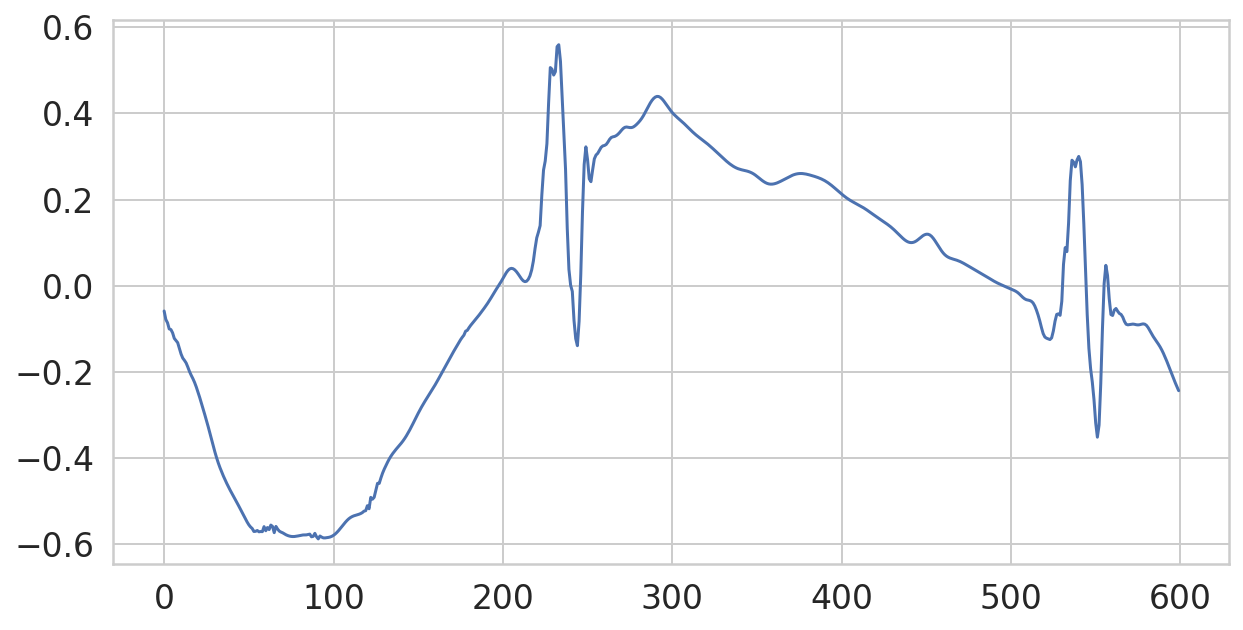

In [29]:
print('Prediction: {}'.format(ot[2]))
sns.lineplot(data=x_test_raw[2, :600, 11])
plt.show();

Not an expert but it seems inverted so it should be OK

# Conclusion

Data were already cleaned, I decided to still apply some pre-processing since I already worked a little bit with ECG and I had some parameters already tuned. Data standardisation should also be correct but it might be interesting to explore different options. The training dataset was perfectly balanced so I did not implement any sophicasted sampling strategy, just a stratification on the labels. I did not introduce data augmentation techiques since I am not sure I could identify the most suited techinques without doing some bibliography in the first place.

For the model type a deep neural network seemed the obsious choice. I still tried a random forest since it took no time to implement. Convolutional network seemed the more appropriate coiche when considering the data type if compared to just using dense layers, rnn or transformers. I used 1D convolution with a kernel size compatible with the sampling frequency and I did some hyperparameters optimization for the filters and the depth of the network. I did not find satisfactory results with a more deep architecture but it might be worth to explore more the impact of hyperparameters, residual convolutions and lstm layers. An initial grid search with the tensorboard hparams should be enough to see if there is potential.

Ensemble learning should also help with the generalization of the results on the test set. I expect he model to reach an accuracy >95% on the test set.

Let me know if you got any question.

See you soon,
Alessandro